# Tensorflow and Machine Learning
Today we will be learning about the popular machine learning API, TensorFlow. 
<br>  - Primarily for deep neural networks.
<br>  - Developed by the Google Brain team.
<br>  - Allows for rapid construction and efficient processing.
<br>  - Can run on multiple CPUs and GPUs.
<br>  - Primary benefit: The user no longer has to explicitly code gradient computations (backpropagation in NN) used for optimization.

In [42]:
# Import numpy, just in case.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [43]:
# May need to install on machine?
import tensorflow as tf
tf.reset_default_graph()

## The Tensorflow Graph 
<br>  - Every opertaion in your model is added to the graph.
<br>  - The graph is constructed before any numerical computing occurs. 

In [44]:
graph = tf.get_default_graph()
print(graph.get_operations())

[]


In [45]:
# Make a matrix, set the matrix as a Tensorflow constant (numerical object with Tensorflow class "Tensor")
a = np.random.randn(2,2)
A = tf.constant(a)
print('Numpy a: \n', a)
print('Tensorflow A: \n ', A)

Numpy a: 
 [[ 0.29144303  0.84121434]
 [-0.46173396  1.41393548]]
Tensorflow A: 
  Tensor("Const:0", shape=(2, 2), dtype=float64)


### While 'a' is in memory as a numpy array with numerical values, 'A' is stored as an object. <br> To retrieve these values we must run the variable in a 'session'.

In [46]:
# Let's use the standard syntax for creating a session object to run parts of our graph. 
sess = tf.Session()
sess.run(A)

array([[ 0.29144303,  0.84121434],
       [-0.46173396,  1.41393548]])

### Try running the cell again, note that the values do not change. 'A' is referencing already generated values of 'a' stored in memory via the numpy function call.

### Now run this cell a few times. What changes? 

In [47]:
# Let's use Tensorflow for this...
B = tf.random_normal([2,2])
print('Without running via a session: \n', B)
print('With a session, \n', sess.run(B))

Without running via a session: 
 Tensor("random_normal:0", shape=(2, 2), dtype=float32)
With a session, 
 [[0.12808524 0.48762745]
 [1.0338162  0.48015445]]


In [48]:
# Try printing the graph operations again.
print(graph.get_operations())

[<tf.Operation 'Const' type=Const>, <tf.Operation 'random_normal/shape' type=Const>, <tf.Operation 'random_normal/mean' type=Const>, <tf.Operation 'random_normal/stddev' type=Const>, <tf.Operation 'random_normal/RandomStandardNormal' type=RandomStandardNormal>, <tf.Operation 'random_normal/mul' type=Mul>, <tf.Operation 'random_normal' type=Add>]


### A key takeaway here is that Tensorflow has a lot going on 'under the hood' to keep track of every operation added to the graph and that tf.Tensor does not return a value outside of a session.

### Next, we will aim to apply tensorflow to run a logistic regression on a binary classification problem.

# Classification via ML Algortihms
Today we will focus on two types of machine learning methods to perform binary classification. 
<br> - Logistic Regression 
<br> - Simple, 1 layer Neural Network

## Logistic Regression

Objective: Map data from input $X$ (n features, m examples) to output $Y$ (vector with values 0 or 1 for each training example). 

Accomplished using the sigmoid function 
## $\sigma(Z) = \frac{1}{1 + e^{-Z}}$

<p><a href="https://commons.wikimedia.org/wiki/File:Logistic-curve.svg#/media/File:Logistic-curve.svg"><img src="https://upload.wikimedia.org/wikipedia/commons/8/88/Logistic-curve.svg" alt="Logistic-curve.svg" height="145" width="218"></a><br>By <a href="//commons.wikimedia.org/wiki/User:Qef" title="User:Qef">Qef</a> (<a href="//commons.wikimedia.org/wiki/User_talk:Qef" title="User talk:Qef">talk</a>) - Created from scratch with gnuplot, Public Domain, <a href="https://commons.wikimedia.org/w/index.php?curid=4310325">Link</a></p>

<br> To build this model we will first need to generate $Z$ from $X$ and then use the activation $\sigma(Z) == \hat{Y}$ which is out output array of predicted binary class probabilities.
## $Z = W^{T}X + b $ 
<br> Where $W$ is a vector of weights and $b$ is a bias term.
## $\hat{Y} = \sigma(Z)$ 
__NOTE__: Later we will refer to $\sigma()$ as a general activation function $g()$ 

Without excessive motivation, the cost or objective function over the whole training set $X$ can be defined as:

## $ J(W,b) = \frac{1}{m}\sum_{i=1}^{m}[-y_i\log{(\hat{y_i})} - (1-y_i)\log{(1-\hat{y_i})}]$

Which is known as the log-loss function
<br>Note: We have defined a non-linear function that must use an optimization technique to solve for these parameters.
Because the gradient of the cost $J$ can be defined, it is standard practice to solve for the gradient of the cost with respect to $W$ and $b$ and use this information with a gradient descent optimizer.
<br> This is accomplished through what I will go ahead and refer to as backpropagation which is machine learning terminology for defining a computation gradient of the cost function using the __chain rule__ from calculus.

<br> This is a very tedious process which I reccomend you explore in a machine learning course if you desire. Luckily for us today, we will introduce Tensorflow, a graph based machine learning API that keeps track of our calculations and computes the gradients of the parameters for us. 

(2, 500)


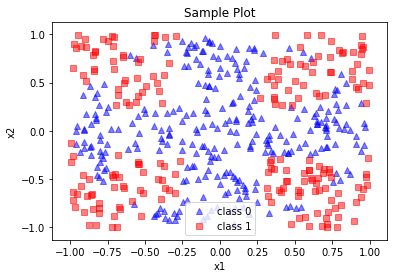

In [51]:
#Let's load the data set for the day

data = pd.read_csv('tfdata.csv', header = None)
X = np.array(data[[0,1]])
X = X.T
n, m = X.shape
y = np.array(data[2]).reshape(1, m)

# Define a plot fn to view the planar data we wish to classify
def plotdata(X, y):
    y = np.squeeze(y)
    fig = plt.figure(num = 1)
    ax1 = fig.add_subplot(111)
    for l, c, m in zip(range(2), ('blue', 'red'), ('^', 's')):
        ax1.scatter(X[0,:][y == l], X[1,:][y == l],
            color=c,
            label='class %s' % l,
            alpha=0.5,
            marker=m)
    ax1.set_xlabel('x1')
    ax1.set_ylabel('x2')
    ax1.set_title('Sample Plot')
    plt.legend(loc = 'best')
    plt.show()

plotdata(X,y)

In [25]:
# First let's clear the graph to build our model.
tf.reset_default_graph()

In [26]:
def LRmodel(X, W, b):
    # X is n features x m examples input matrix
    # W is (1,n features) weights array
    # b.shape = (1, 1) bias value.
    
    Z = tf.matmul(W,X) + b
    
    return tf.sigmoid(Z)
    

### This is a model function, it has not been added to the graph yet

In [27]:
def LRtrain(X_train, Y_train, iterations = 100, learning_rate = 0.001, thresh = 0.75):
    # X should be passed to the function as a n x m matrix
    # Y should be 1 x m
    
    n, m = X_train.shape
    
    # We define a placeholder with a variable amount of training examples for the purpose of buidling the graph.
    X = tf.placeholder(shape = (n, None), dtype = tf.float32)
    Y = tf.placeholder(shape = (1, None), dtype = tf.float32)
    
    # Declare our parameters
    W = tf.get_variable('W', [1, n], initializer= tf.contrib.layers.xavier_initializer())
    b = tf.get_variable('b', [1, 1], initializer= tf.zeros_initializer())
    
    
    # Obtain y_hat or tentative predictions
    y_hat = LRmodel(X, W, b)
    
    
    # Define a cost function
    cost = tf.losses.log_loss(Y, y_hat)
    
    # Define an optimeizer object
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost)
    
    # Define a weight initializer object
    init = tf.global_variables_initializer()
    
    # Start the session
    with tf.Session() as sess:
        # Initialize the variables
        sess.run(init)
        
        # Run update parameters over a preset number of iterations (for the class demo purposes only)
        for i in range(iterations):
            _, err = sess.run([optimizer, cost], feed_dict= {X:X_train, Y:Y_train})
            
            if i%1000 == 0:
                print(err)
        
        # Define an accuracy protocol
        prediction = tf.cast(tf.greater(y_hat, thresh), tf.float32)
        evaluate_predict = tf.equal(prediction, Y)
        accuracy = tf.reduce_mean(tf.cast(evaluate_predict, "float"))
        
    
        print('Logistic regression training set accuracy = ', accuracy.eval({X:X_train, Y:Y_train}))
        # Include a printout of the scatter plot and decision boundary
        
    return W, b
    
    

In [39]:
# Run the logistic regression training step and see how we do.
tf.reset_default_graph()
W, b = LRtrain(X, y, iterations=10000, learning_rate= 0.01)


0.7792399
0.7002721
0.68550366
0.68253326
0.68195385
0.6818418
0.6818201
0.6818159
0.68181515
0.681815
Logistic regression training set accuracy =  0.574


# Neural Networks
To extend the ideas of logistic regression, we will now add in a "hidden" layer, expanding or contracting our input dimension to a different space. Let's examine this graphically:
## Before with logistic regression,

![LR Figure](lrfig.png)

## Now, with a single layer added,

![NN Figure](nnfig.png)




For a simple 1 layer neural network:

<br> $ a^{[1]} = g^{[1]}(W^{[1]}X + b^{[1]}) $
<br> $ a^{[2]} = g^{[2]}(W^{[2]}a^{[1]} + b^{[2]}) $    Where $ a^{[2]} $ is our output activation/class probability and $g^{[2]}$ is a sigmoid function.

### To start, define the paramters to be initialized in a single function call.

In [29]:
def add_params(n_feat, layer_size):
    
    # n_feat is the number of features in the sample
    # layer_size is the size of layer 1, the only layer in the NN
    params = {}
    params['W1'] = tf.get_variable('W1', [layer_size, n_feat], initializer= tf.contrib.layers.xavier_initializer())
    params['b1'] = tf.get_variable('b1', [layer_size, 1], initializer= tf.zeros_initializer())
    params['W2'] = tf.get_variable('W2', [1, layer_size], initializer= tf.contrib.layers.xavier_initializer())
    params['b2'] = tf.get_variable('b2', [1, 1], initializer= tf.zeros_initializer())
    return params

### Now let's define the model we are using or in deep learning terms, define the forward propagation.

In [30]:
def NNmodel(X, params):
    # X is n_feat x m examples
    # params = a dict containing the parameters we previously deifned.
    
    
    # Retrieve the parameters
    W1 = params['W1']
    b1 = params['b1']
    W2 = params['W2']
    b2 = params['b2']
    
    # Now implement the forward propagation using tensorflow
    a1 = tf.nn.relu(tf.matmul(W1, X) + b1)
    a2 = tf.sigmoid(tf.matmul(W2, a1) + b2)
    
    return a2

### Great! Let's define a training function similar to before to train our NN.

In [31]:
def NNtrain(X_train, Y_train, layer_size = 10, iterations = 100, learning_rate = 0.001, thresh = 0.75):
    # X should be passed to the function as a n x m matrix
    # Y should be 1 x m
    
    n, m = X_train.shape
    
    # We define a placeholder with a variable amount of training examples for the purpose of buidling the graph.
    X = tf.placeholder(shape = (n, None), dtype = tf.float32)
    Y = tf.placeholder(shape = (1, None), dtype = tf.float32)
    
    # add our model parameters to the graph variables
    params = add_params(n, layer_size)
    
    
    # Obtain y_hat or tentative predictions
    y_hat = NNmodel(X, params)
    
    
    # Define a cost function
    cost = tf.losses.log_loss(Y, y_hat)
    
    # Define an optimeizer object
    optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(cost)
    
    
    # Define a weight initializer object
    init = tf.global_variables_initializer()
    
    # Start the session
    with tf.Session() as sess:
        # Initialize the variables
        sess.run(init)
        
        # Run update parameters over a preset number of iterations (for the class demo purposes only)
        for i in range(iterations):
            _, err = sess.run([optimizer, cost], feed_dict= {X:X_train, Y:Y_train})
            
            if i%1000 == 0:
                print(err)
        
        prediction = tf.cast(tf.greater(y_hat, thresh), tf.float32)
        evaluate_predict = tf.equal(prediction, Y)
        accuracy = tf.reduce_mean(tf.cast(evaluate_predict, "float"))
        print('Neural network training set accuracy = ', accuracy.eval({X:X_train, Y:Y_train}))
        # Include a printout of the scatter plot and decision boundary
    return params
    

In [40]:
tf.reset_default_graph()

params = NNtrain(X, y, layer_size= 10, iterations = 10000, learning_rate= 0.01)

0.70063716
0.6566959
0.6309035
0.6027601
0.5745586
0.54828686
0.52552265
0.5070622
0.492835
0.48223087
Neural network training set accuracy =  0.714


Wow! That's quite an improvement for only adding one layer with a few hidden units. As the amount of layers and units increase, the model can learn more and more complex patterns. However, adding layers or increasing the amount of hidden units does not always yield better prediction performance and can make some problems computationally intractable. 